<a href="https://colab.research.google.com/github/ssvakil/Machine-Learning-in-Python-Workshop/blob/master/adversarial%20attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "/content/drive/MyDrive/Colab Notebooks/lenet_mnist_model.pth"
use_cuda=True

In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)
import torch.utils.data as data_utils

# indices = torch.arange(100)
# test_loader = data_utils.Subset(test_loader, indices)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

100%|██████████| 9912422/9912422 [00:00<00:00, 357997754.70it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111337953.88it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 104540720.98it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6603302.87it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

$\mathbf{x}$ is the original input image
correctly classified as a “panda”, $y$ is the ground truth label
for $\mathbf{x}$, $\mathbf{\theta}$ represents the model
parameters, and $J(\mathbf{\theta}, \mathbf{x}, y)$ is the loss
that is used to train the network. The attack backpropagates the
gradient back to the input data to calculate
$\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$. Then, it adjusts
the input data by a small step ($\epsilon$ or $0.007$ in the
picture) in the direction (i.e.
$sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$) that will
maximize the loss. The resulting perturbed image, $x'$, is then
*misclassified* by the target network as a “gibbon” when it is still
clearly a “panda”.

### FGSM Attack

Now, we can define the function that creates the adversarial examples by
perturbing the original inputs. The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}

Finally, in order to maintain the original range of the data, the
perturbed image is clipped to range $[0,1]$.




In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    nsamples = 1000


    # Loop over all examples in test set
    for i,(data, target) in enumerate(test_loader):
        if i > nsamples:
            break
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 985 / 10000 = 0.0985
Epsilon: 0.05	Test Accuracy = 947 / 10000 = 0.0947
Epsilon: 0.1	Test Accuracy = 859 / 10000 = 0.0859
Epsilon: 0.15	Test Accuracy = 685 / 10000 = 0.0685
Epsilon: 0.2	Test Accuracy = 431 / 10000 = 0.0431
Epsilon: 0.25	Test Accuracy = 228 / 10000 = 0.0228
Epsilon: 0.3	Test Accuracy = 87 / 10000 = 0.0087


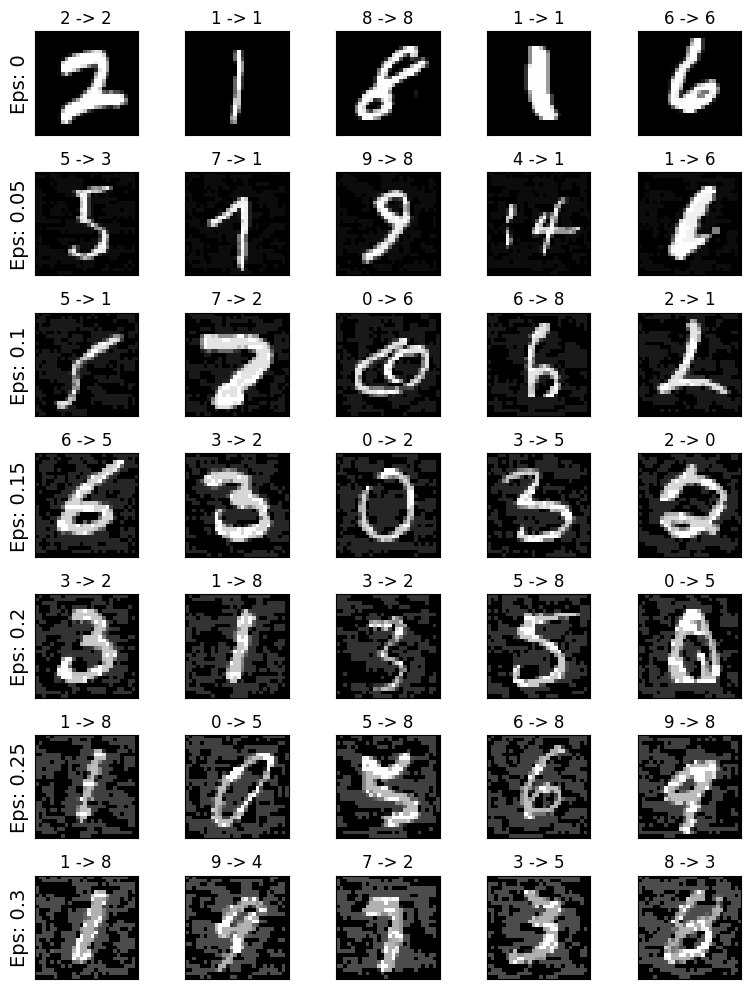

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    nsamples = 1000


    # Loop over all examples in test set
    for i,(X,y) in enumerate(loader):
        if i > nsamples:
            break
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
epoch_adversarial(model, test_loader, pgd, 0.1,1e4, 20)

(0.0384, 0.12091129047572613)

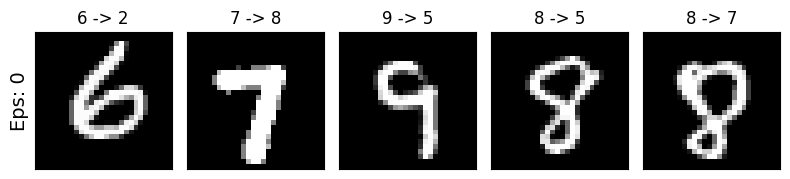

In [ ]:
accuracies = []
examples = [[]]

# Run test for each epsilon
nsamples = 4


    # Loop over all examples in test set
for i,(X,y) in enumerate(test_loader):
    if i > nsamples:
            break
    X,y = X.to(device), y.to(device)
    delta = pgd(model, X, y, 0.2, 1e-1, 1000)
    yp = model(X+delta).max(1, keepdim=True)[1].cpu()
    examples[0].append((y.item(),yp.item(),X.squeeze().detach().cpu().numpy()))
cnt = 0
plt.figure(figsize=(8,10))
for i in range(1):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(1,len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

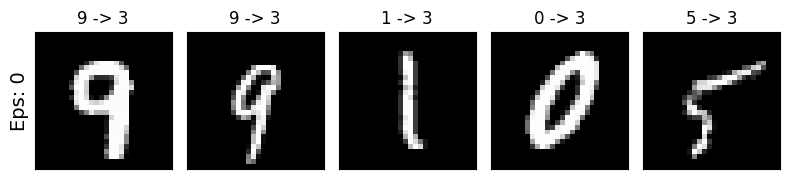

In [ ]:
accuracies = []
examples = [[]]

# Run test for each epsilon
nsamples = 4


    # Loop over all examples in test set
for i,(X,y) in enumerate(test_loader):
    if i > nsamples:
            break
    X,y = X.to(device), y.to(device)
    delta = pgd_linf_targ(model, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=3)
    yp = model(X+delta).max(1, keepdim=True)[1].cpu()
    examples[0].append((y.item(),yp.item(),X.squeeze().detach().cpu().numpy()))
cnt = 0
plt.figure(figsize=(8,10))
for i in range(1):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(1,len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()